Waakvlam analyse

In [1]:
import zipfile
import pandas as pd
import numpy as np
# bokeh libraries
from bokeh.io import output_notebook, output_file
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool, Legend, HoverTool
from bokeh.plotting import figure, show

#set rendering to notebook
output_notebook()

# #uncomment the following two lines if you get an SSL error when downloading the data
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

path = "https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/daggegevens/etmgeg_260.zip"
df = pd.read_csv(path,compression='zip', skiprows=51, low_memory=False)
df.head()

Loading BokehJS ...

,# STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,260,19010101,,,,,,,,,...,,,,,66,,,,,
1,260,19010102,,,,,,,,,...,,,,,86,,,,,
2,260,19010103,,,,,,,,,...,,,,,89,,,,,
3,260,19010104,,,,,,,,,...,,,,,79,,,,,
4,260,19010105,,,,,,,,,...,,,,,65,,,,,


In [2]:
def preprocess(df):
    """
    preprocess 'de bilt etmaalgegevens' for analysis
    
    parameters: raw dataframe
    returns: cleaned dataframe
    
    """
    #FG = Etmaalgemiddelde windsnelheid (in 0.1 m/s) 
    #TG = Etmaalgemiddelde temperatuur (in 0.1 graden Celsius) 
    #YYYYMMDD = timestamp
    
    threshold_value = -6.5  

    df = df.rename(columns={"YYYYMMDD": "datum", "   TG": "etmaal_temperatuur", "   FG": "etmaal_windsnelheid"}, 
              errors="raise")
    df = df[['datum', 'etmaal_temperatuur', 'etmaal_windsnelheid']]
    df['datum'] = pd.to_datetime(df['datum'], format='%Y%m%d', errors='coerce')
    df['etmaal_temperatuur'] = df['etmaal_temperatuur'].astype('float64')
    df['etmaal_windsnelheid'] = pd.to_numeric(df['etmaal_windsnelheid'], errors='coerce')
    df.etmaal_temperatuur = df.etmaal_temperatuur/10
    df.etmaal_windsnelheid= df.etmaal_windsnelheid/10
    df['effectief'] = df['etmaal_temperatuur'] - (df['etmaal_windsnelheid']/1.5)
    df['waakvlam'] = df['effectief'] < threshold_value
    df['alarmtemp'] = df['effectief'].apply(lambda x: x if x < threshold_value else None)

    df_sorted = df.sort_values(by='datum')
    
    return df_sorted

In [3]:
df = preprocess(df)
display(df.head())
print(df.shape)

,datum,etmaal_temperatuur,etmaal_windsnelheid,effectief,waakvlam,alarmtemp
0,1901-01-01,-4.9,NaN,NaN,False,NaN
1,1901-01-02,-1.8,NaN,NaN,False,NaN
2,1901-01-03,-2.6,NaN,NaN,False,NaN
3,1901-01-04,-6.5,NaN,NaN,False,NaN
4,1901-01-05,-6.0,NaN,NaN,False,NaN


(45093, 6)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45093 entries, 0 to 45092
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datum                45093 non-null  datetime64[ns]
 1   etmaal_temperatuur   45093 non-null  float64       
 2   etmaal_windsnelheid  43968 non-null  float64       
 3   effectief            43968 non-null  float64       
 4   waakvlam             45093 non-null  bool          
 5   alarmtemp            839 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float64(4)
memory usage: 2.1 MB


<AxesSubplot:ylabel='Frequency'>

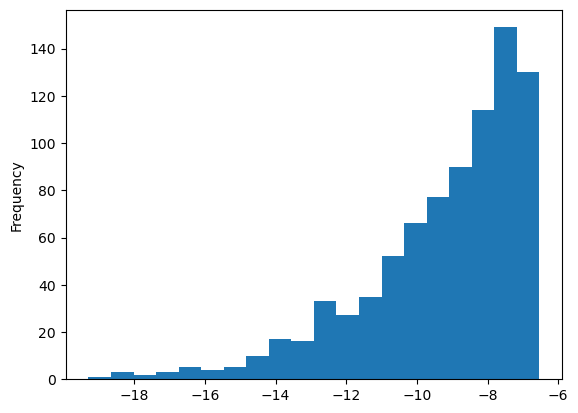

In [4]:
df.alarmtemp.plot(kind='hist', bins=20)

In [8]:
df['jaar'] = df.datum.dt.year

# Group by the 'year' column
grouped_df = df.copy().groupby('jaar')


# Now you can perform operations on each group
# For example, to get the mean temperature for each year
temperatures = grouped_df['waakvlam'].sum()
temperatures.tail(15)

jaar
2010     8
2011     0
2012    10
2013     7
2014     0
2015     0
2016     0
2017     0
2018     4
2019     0
2020     0
2021     4
2022     0
2023     0
2024     0
Name: waakvlam, dtype: int64

In [11]:
df.waakvlam.max()

True

In [12]:
df[df.waakvlam==True].to_csv('tempdata.csv')
df = df.set_index('datum')

In [14]:
# source: https://docs.bokeh.org/en/latest/docs/user_guide/topics/timeseries.html

dates = np.array(df.index, dtype=np.datetime64)
source = ColumnDataSource(data=dict(date=dates, eet=df['effectief'], alarm=df['alarmtemp']))

p = figure(height=300, width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[-2500], dates[-1]))

p.circle('date', 'eet', source=source, color='blue', legend_label='effectieve etmaal temperatuur', alpha=0.5, size=1)
p.circle('date', 'alarm', source=source, color='red', legend_label='onder -6.5', alpha=0.7, size=5)
p.line('date', 'eet', source=source, color='lightgrey')
p.yaxis.axis_label = 'temperatuur'

select = figure(title="selectie van gewenste data range",
                height=130, width=800, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.circle('date', 'eet', source=source, color='blue', alpha=0.3, size=1)
select.circle('date', 'alarm', source=source, color = 'red', alpha=0.3, size=5)

select.ygrid.grid_line_color = None
select.add_tools(range_tool)

# Add HoverTool
hover = HoverTool(tooltips=[("Date", "@date{%F}"), ("EET", "@eet")], formatters={"@date": "datetime"})
p.add_tools(hover)

p.add_layout(Legend(), 'right')

output_file("waakvlam_alarm.html")
show(column(p, select))
